# Exercice 2
## Contexte
Ici le but est de trouver un modèle de prédiction pour la réaction d'un traitement sur des patients atteints de cancer du sein. La variable à prédire est `treat-ment_response` en utilisant tout d'abord les données liée aux caractéristiques génétiques.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('GSE16716-BreastCancers.csv')
print(df.shape)
# inversé les colonnes et les lignes
df = df.T
print(df.shape)
# récuperer les noms des colonnes
df.columns = df.iloc[0]
print(df.columns)
# supprimer la première ligne
df = df[1:]
# on garde les données qui nous intéressent
colonne_a_supprimer = ['Sample_title', 'tissue', 'age', 'ethnicity','histology','treatment code','MAQC_Distribution_Status','ID_REF']
df = df.drop(colonne_a_supprimer, axis=1)
df = df.reset_index(drop=True)
print(df.columns)

(22298, 279)
(279, 22298)
Index(['Sample_title', 'tissue', 'age', 'ethnicity', 'treatment_response',
       'T (tumor)', 'N (Node)', 'bmn_grade', 'PR_status: ', 'ER_status: ',
       ...
       'AFFX-r2-Hs28SrRNA-5_at', 'AFFX-r2-Hs28SrRNA-M_at',
       'AFFX-r2-P1-cre-3_at', 'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at',
       'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at',
       'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at'],
      dtype='object', name='Sample_geo_accession', length=22298)
Index(['treatment_response', 'T (tumor)', 'N (Node)', 'bmn_grade',
       'PR_status: ', 'ER_status: ', 'her2_status', '1007_s_at', '1053_at',
       '117_at',
       ...
       'AFFX-r2-Hs28SrRNA-5_at', 'AFFX-r2-Hs28SrRNA-M_at',
       'AFFX-r2-P1-cre-3_at', 'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at',
       'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at',
       'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at'],
      dtype='object', name='Sample_geo_accession', length=22290)


C:\Users\alexa\AppData\Local\Temp\ipykernel_18756\526527239.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

## Nettoyage des données
On va commencer par donner le bon type à nos variables, toutes nos variables génétiques sont des float, on va donc les convertir en float et on va vérifier s'il y a des valeurs manquantes, pour nos autres variables on va les convertir en variables catégorielles.


In [7]:
non_numeric_cols = ['treatment_response', 'PR_status: ', 'ER_status: ', 'her2_status','T (tumor)', 'N (Node)']
# Colonnes à convertir
numeric_cols = [col for col in df.columns if col not in non_numeric_cols]

# Conversion en float
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Valeurs manquantes dans les colonnes converties
missing_values = df[numeric_cols].isnull().sum()
print("valeur manquante : ",missing_values[missing_values > 0])
print("valeur cible",df['bmn_grade'].value_counts())


valeur manquante :  Sample_geo_accession
bmn_grade    13
dtype: int64
valeur cible bmn_grade
3.0    148
2.0    104
1.0     13
Name: count, dtype: int64


On peut voir qu'il n'y a que la variable `bmn_grade` qui a des valeurs manquante, mais cette variable semble être catégorielle on va donc remplacer les valeurs manquantes par la valeur la plus fréquente. Pour nos autres variabels non numériques on va les convertir en variables catégorielles.

In [8]:
from sklearn.preprocessing import LabelEncoder

# Remplacement des valeurs manquantes par la valeur la plus fréquente
df['bmn_grade'] = df['bmn_grade'].fillna(df['bmn_grade'].mode()[0])
print(df['bmn_grade'].value_counts())
# Conversion des variables catégorielles en vecteur one hot
for col in non_numeric_cols:
    print(df[col].value_counts())
    print('-------------------')

# On remarque qu'il y a quelque valeurs mal transformées, on va les supprimer
# Remplacer les valeurs incorrectes pour `treatment_response`
df = df[df['treatment_response'].isin(['RD', 'pCR'])]

# Nettoyer `PR_status`
df['PR_status: '] = df['PR_status: '].replace({
    'tbefore: 3': None,
    'nbefore: 2': None,
    'her2 ihc: NA': None
}).dropna()

# Nettoyer `ER_status`
df['ER_status: '] = df['ER_status: '].replace({
    'pcr_vs_rd: RD': None,
    'pr_status: N': None,
    'pcr_vs_rd: pCR': None
}).dropna()

# Nettoyer `her2_status`
df['her2_status'] = df['her2_status'].replace({
    'her2 ihc: 0': None,
    'her2 ihc: NEG': None,
    'histology: IDC': None,
    'histology: ILC': None,
    'treatment code: TXFAC': None,
    'her2 ihc: ND': None,
    'her2 fish: 3': None,
    'her2 fish: 1.5': None,
    'her2 fish: 1.06': None,
    'her2 ihc: 3': None,
    'her2 ihc: 2': None,
    'her2 fish: 1.9': None
}).dropna()

# Nettoyer `T (tumor)`
df['T (tumor)'] = df['T (tumor)'].replace({
    'nbefore: 0': None,
    'nbefore: 1': None,
    'nbefore: 2': None,
    'her2 status: P': None,
    'treatment code: NA': None
}).dropna()

# Nettoyer `N (Node)`
df['N (Node)'] = df['N (Node)'].replace({
    'her2 status: N': None,
    'bmngrd: 3': None,
    'her2 ihc: 2+': None,
    'her2 status: P': None
}).dropna()
# On re vérifie les valeurs
print("-----VERIFICATION DES VALEURS-----")
for col in non_numeric_cols:
    print(df[col].value_counts())
    print('-------------------')

# Encodage de la variable cible
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['treatment_response'])
# Supprimer la cible des données
df = df.drop(columns=['treatment_response'])

# Liste des colonnes catégorielles sans la cible
categorical_cols = [col for col in non_numeric_cols if col != 'treatment_response']

# Transformation en indicateurs
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# Concaténation de la cible
df['y'] = y
print(df.head())

bmn_grade
3.0    161
2.0    104
1.0     13
Name: count, dtype: int64
treatment_response
RD                213
pCR                55
pr_status: N        6
pr_status: P        3
her2 status: N      1
Name: count, dtype: int64
-------------------
PR_status: 
N               150
P               118
tbefore: 3        8
nbefore: 2        1
her2 ihc: NA      1
Name: count, dtype: int64
-------------------
ER_status: 
P                 161
N                 107
pcr_vs_rd: RD       8
pr_status: N        1
pcr_vs_rd: pCR      1
Name: count, dtype: int64
-------------------
her2_status
N                        203
P                         55
her2 ihc: 0                3
her2 ihc: NEG              2
histology: IDC             2
treatment code: TXFAC      2
histology: ILC             2
her2 ihc: ND               1
her2 fish: 3               1
her2 fish: 1.5             1
her2 fish: 1.06            1
her2 ihc: 3                1
her2 ihc: 2                1
her2 fish: 1.9             1
Name: count,

Maintenant que le nettoyage des données est fait on va pouvoir commencer à faire des analyses sur nos données.

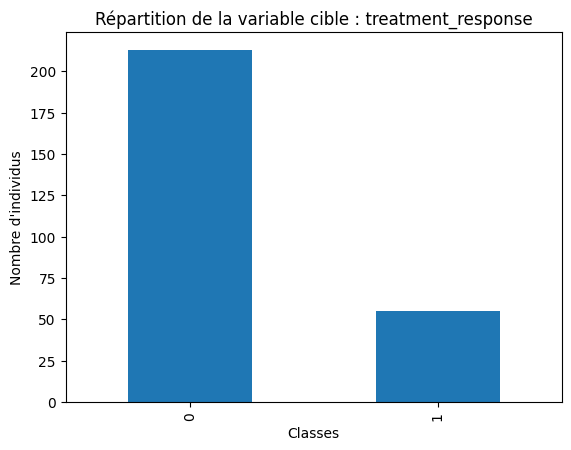

Top 10 des variables les plus corrélées avec la cible :
y              1.000000
204822_at      0.368178
204825_at      0.352977
213134_x_at    0.352175
201555_at      0.350905
203693_s_at    0.346549
205548_s_at    0.343258
221253_s_at    0.336383
206392_s_at    0.333784
206391_at      0.330762
Name: y, dtype: float64


In [9]:
import matplotlib.pyplot as plt

# Distribution de la variable cible
df['y'].value_counts().plot(kind='bar')
plt.title('Répartition de la variable cible : treatment_response')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'individus')
plt.show()

import seaborn as sns

# Matrice de corrélation
correlation_matrix = df.corr()
# Corrélation avec la cible
target_corr = correlation_matrix['y'].sort_values(ascending=False)
print("Top 10 des variables les plus corrélées avec la cible :")
print(target_corr.head(10))

Globalement on peut voir que les variables ne sont pas très corrélées avec la variable cible, on va donc essayer de faire une réduction de dimension pour voir si on peut avoir de meilleurs résultats.

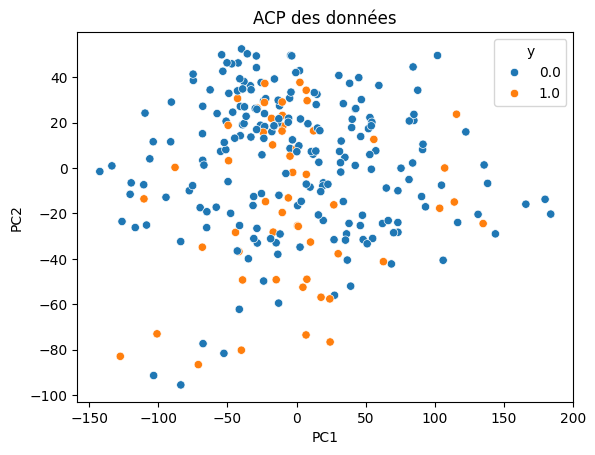

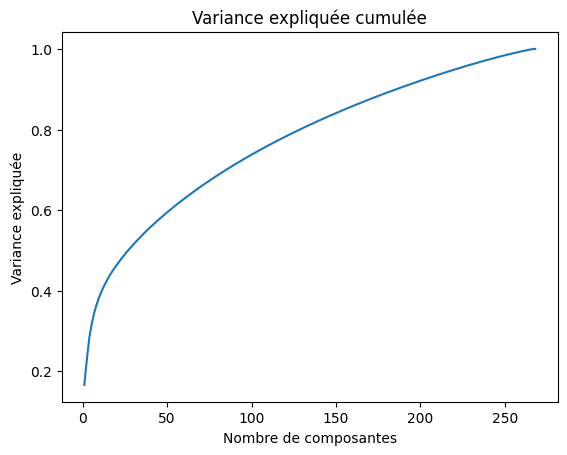

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Séparation des données
X = df.drop(columns=['y'])
y = df['y']

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de dimension
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Création d'un DataFrame pour la visualisation
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['y'] = y

# Visualisation
sns.scatterplot(x='PC1', y='PC2', hue='y', data=pca_df)
plt.title('ACP des données')
plt.show()

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Calculate explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.title('Variance expliquée cumulée')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée')
plt.show()

On va garder 95% de la variance expliquée, on va donc garder autour de 230 composantes.

In [11]:
# garder 230 composantes
pca = PCA(n_components=230)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)


(268, 230)


## Modélisation
On va maintenant essayer de trouver un modèle de prédiction pour notre variable cible, on va commencer par diviser nos données en données d'entraînement et données de test. Pour comparer nos modèles on va utiliser le F1 Score.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# dict pour stocker les résultats
results = {}

### Régression logistique

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Modèle
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)

# Prédictions
y_pred_log = log_model.predict(X_test)

# Évaluation
print("Régression logistique")
print(classification_report(y_test, y_pred_log))
print("F1 Score (macro) :", f1_score(y_test, y_pred_log, average='macro'))
results['Logistic Regression'] = f1_score(y_test, y_pred_log, average='macro')

Régression logistique
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       0.57      0.44      0.50         9

    accuracy                           0.85        54
   macro avg       0.73      0.69      0.71        54
weighted avg       0.84      0.85      0.84        54

F1 Score (macro) : 0.7065217391304348


### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Définir la grille de paramètres
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialiser le modèle
rf = RandomForestClassifier(random_state=42)

# Utiliser F1 Score (macro) comme métrique de scoring
scorer = make_scorer(f1_score, average='macro')

# Recherche par grille
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=scorer, cv=5, verbose=0, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Meilleur modèle
best_rf = grid_search_rf.best_estimator_

# Évaluation sur le jeu de test
y_pred_rf = best_rf.predict(X_test)
print("Meilleur modèle Random Forest :", grid_search_rf.best_params_)
print("F1 Score (macro) :", f1_score(y_test, y_pred_rf, average='macro'))
results['Random Forest'] = f1_score(y_test, y_pred_rf, average='macro')

Meilleur modèle Random Forest : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
F1 Score (macro) : 0.45454545454545453


### SVM

In [14]:
from sklearn.svm import SVC

# Définir la grille de paramètres
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Initialiser le modèle
svm = SVC(class_weight='balanced', random_state=42)

# Recherche par grille
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring=scorer, cv=5, verbose=0, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Meilleur modèle
best_svm = grid_search_svm.best_estimator_

# Évaluation sur le jeu de test
y_pred_svm = best_svm.predict(X_test)
print("Meilleur modèle SVM :", grid_search_svm.best_params_)
print("F1 Score (macro) :", f1_score(y_test, y_pred_svm, average='macro'))
results['SVM'] = f1_score(y_test, y_pred_svm, average='macro')

Meilleur modèle SVM : {'C': 1, 'kernel': 'sigmoid'}
F1 Score (macro) : 0.7137349397590362


### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Définir la grille de paramètres
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}

# Initialiser le modèle
knn = KNeighborsClassifier()

# Recherche par grille
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring=scorer, cv=5, verbose=0, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Meilleur modèle
best_knn = grid_search_knn.best_estimator_

# Évaluation sur le jeu de test
y_pred_knn = best_knn.predict(X_test)
print("Meilleur modèle KNN :", grid_search_knn.best_params_)
print("F1 Score (macro) :", f1_score(y_test, y_pred_knn, average='macro'))

Meilleur modèle KNN : {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
F1 Score (macro) : 0.45454545454545453


### Gradient Boosting


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

# Définir la grille de paramètres
param_grid_gb = {
    'n_estimators': [100, 200, 300],         # Nombre d'arbres
    'learning_rate': [0.01, 0.1, 0.2],      # Taux d'apprentissage
    'max_depth': [3, 5, 10],                # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],        # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]           # Nombre minimum d’échantillons dans une feuille
}

# Initialiser le modèle
gb = GradientBoostingClassifier(random_state=42)

# Recherche par grille
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, scoring=scorer, cv=5, verbose=0, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Meilleur modèle et paramètres
best_gb = grid_search_gb.best_estimator_
print("Meilleurs paramètres pour Gradient Boosting :", grid_search_gb.best_params_)

# Évaluation sur le jeu de test
y_pred_gb = best_gb.predict(X_test)
print("F1 Score (macro) :", f1_score(y_test, y_pred_gb, average='macro'))
results['Gradient Boosting'] = f1_score(y_test, y_pred_gb, average='macro')

Meilleurs paramètres pour Gradient Boosting : {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
F1 Score (macro) : 0.425531914893617


### MLP Classifier

In [17]:
from sklearn.neural_network import MLPClassifier

# Définir la grille de paramètres
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Initialiser le modèle
mlp = MLPClassifier(max_iter=500, random_state=42)

# Recherche par grille
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, scoring=scorer, cv=5, verbose=0, n_jobs=-1)
grid_search_mlp.fit(X_train, y_train)

# Meilleur modèle
best_mlp = grid_search_mlp.best_estimator_

# Évaluation sur le jeu de test
y_pred_mlp = best_mlp.predict(X_test)
print("Meilleur modèle MLP :", grid_search_mlp.best_params_)
print("F1 Score (macro) :", f1_score(y_test, y_pred_mlp, average='macro'))
results['MLP'] = f1_score(y_test, y_pred_mlp, average='macro')

Meilleur modèle MLP : {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
F1 Score (macro) : 0.6487285629804849


## Comparaison des modèles

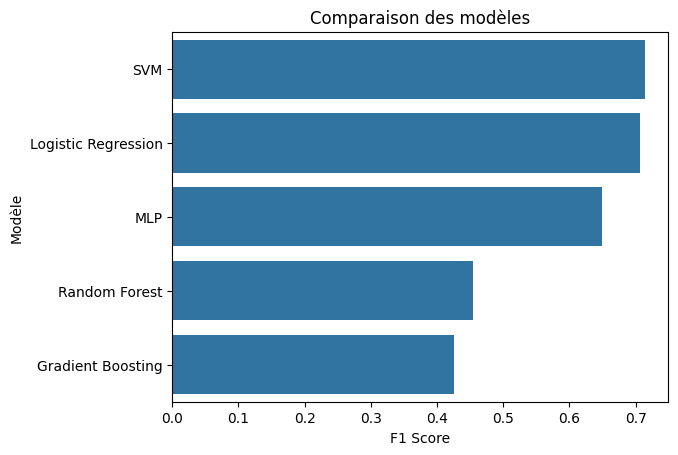

In [18]:
# Comparaison des modèles
results_df = pd.DataFrame(results.items(), columns=['Modèle', 'F1 Score'])
results_df = results_df.sort_values('F1 Score', ascending=False)

# Visualisation
sns.barplot(x='F1 Score', y='Modèle', data=results_df)
plt.title('Comparaison des modèles')
plt.show()


Au final le modèle qui semble le mieux fonctionner est le SVM avec un F1 Score de 0.71.